In [40]:
%load_ext autoreload
%autoreload 2

import sys, os
project_root = os.path.abspath("../..")  # one level up from /notebooks
if project_root not in sys.path:
    sys.path.append(project_root)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [41]:
from astropy.io import fits
import matplotlib.pyplot as plt
import numpy as np
from astropy.visualization import ZScaleInterval, ImageNormalize
from astropy.table import Table
import matplotlib as mpl
from src.analysis import gaussian_weight, wiener_deconvolution, calculate_gaap_flux, align_fluxes_by_reference
from scipy.spatial import cKDTree
import pandas as pd
from multiprocessing.dummy import Pool
from tqdm import tqdm
from astropy.nddata import Cutout2D
import glob
import pickle
from astropy.wcs import WCS
from astropy.coordinates import SkyCoord
import astropy.units as u
import warnings
import cv2
warnings.filterwarnings("ignore")

In [42]:
# Set location data
location = '/net/vdesk/data2/deklerk/GAAP_data'

In [43]:
field = '53.0_-28.0'

In [44]:
aperture_size = 5

  X_IMAGE     Y_IMAGE    FLUX_AUTO   ...   NUMBER   FLAGS CLASS_STAR
    pix         pix          ct      ...                            
----------- ----------- ------------ ... ---------- ----- ----------
 18532.6934      2.1552     1.008306 ...          1    24      0.026
  7735.6421      5.9604    0.9945254 ...          2    16      0.028
   539.5378      3.5310    0.8416553 ...          3    24      0.000
 17127.6895      2.9888    0.8018228 ...          4    24      0.000
 17386.4766      4.0874     1.072105 ...          5    24      0.027
 14171.3564      3.4384     1.024001 ...          6    24      0.000
  1255.4567      9.0779    0.5413543 ...          7    16      0.019
  8636.0039     13.5105     0.651731 ...          8    18      0.000
  7608.9624      3.9101     2.011254 ...          9    24      0.034
 14362.6133      4.5717     1.688722 ...         10    24      0.000
        ...         ...          ... ...        ...   ...        ...
  7549.8633  18465.9902     11.840

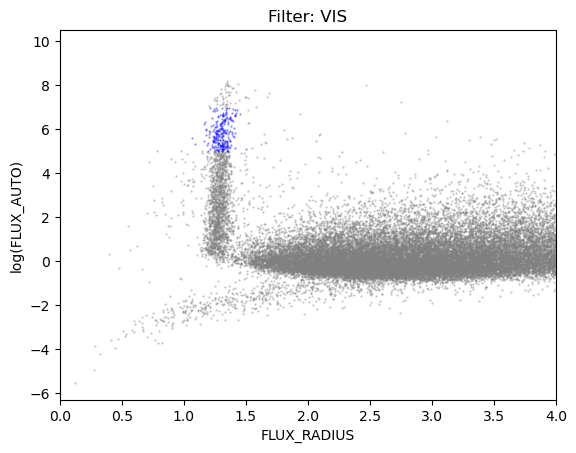

In [45]:
catalog = Table.read(f'{location}/{field}/VIS.cat', format='fits', hdu=2)
print(catalog)
files = glob.glob(f'{location}/{field}/VIS_*.fits')
image_file = [file for file in files if not file.endswith("psf.fits")][0]
hdu = fits.open(image_file)[0]
print(hdu.header)
reference_wcs = WCS(hdu.header)
image_data = hdu.data
ra_reference, dec_reference = reference_wcs.wcs_pix2world(catalog['X_IMAGE'], catalog['Y_IMAGE'], 0)
mask = (
        (np.log(catalog['FLUX_AUTO']) > 5)
        & (np.log(catalog['FLUX_AUTO']) < 7)
        & (catalog['FLUX_RADIUS'] > 1)
        & (catalog['FLUX_RADIUS'] < 1.5)
    )
plt.plot(catalog[~mask]['FLUX_RADIUS'], np.log(catalog[~mask]['FLUX_AUTO']), '.', ms=1, alpha=0.5, color='gray')
plt.plot(catalog[mask]['FLUX_RADIUS'], np.log(catalog[mask]['FLUX_AUTO']), '.', ms=1, alpha=0.5, color='blue')
plt.xlim(0, 4)
plt.title(f'Filter: VIS')
plt.xlabel('FLUX_RADIUS')
plt.ylabel('log(FLUX_AUTO)')
plt.show()
class_star = catalog['CLASS_STAR']

In [46]:
# with open(f'{location}/{field}/master_table_{aperture_size/5}".pkl', 'rb') as f:
#     master_table = pickle.load(f)
# with open(f'{location}/{field}/sigma_table_{aperture_size/5}".pkl', 'rb') as f:
#     sigma = pickle.load(f)

In [47]:
cutout_size = 50
tile_size = 600
dfs = {}
sigma = {}
filters = ['u', 'g', 'r', 'i', 'y', 'z', 'VIS', 'DES-G', 'DES-R', 'DES-I', 'NIR-Y', 'NIR-J', 'NIR-H']

# Step 1: create master IDs for reference coordinates
master_table = pd.DataFrame({
    'id': np.arange(len(ra_reference)),
    'ra': ra_reference,
    'dec': dec_reference,
    'CLASS_STAR': class_star
})

for i, filter in enumerate(filters):
    print(f'Processing filter {filter} ({i+1} of {len(filters)})             ')
    if len(filter) == 1:
        catalog = Table.read(f'{location}/{field}/{filter}.cat', format='ascii')
    else:
        catalog = Table.read(f'{location}/{field}/{filter}.cat', format='fits', hdu=2)
    files = glob.glob(f'{location}/{field}/{filter}_*.fits')
    image_file = [file for file in files if not file.endswith("psf.fits")][0]
    hdul = fits.open(image_file)
    hdu = hdul[1 if len(filter) == 1 else 0]
    wcs = WCS(hdu.header)
    image_data = hdu.data
    nx = hdu.header["NAXIS1"]
    ny = hdu.header["NAXIS2"]
    hdul.close()

    x, y = wcs.wcs_world2pix(ra_reference, dec_reference, 0)
    mask = (x >= 0) & (x < nx) & (y >= 0) & (y < ny)
    x[~mask] = None
    y[~mask] = None

    try:
        psf_file = [file for file in files if file.endswith("psf.fits")][0]
        psf_hdul = fits.open(psf_file)
        psf = psf_hdul[0].data
        psf_hdul.close()
    except Exception:
        print(f'Constructing PSF for {filter} band')
        if filter[:4] == 'DES-':
            mask_stars = (
                (np.log(catalog['FLUX_AUTO']) > 10.5)
                & (np.log(catalog['FLUX_AUTO']) < 12.5)
                & (catalog['FLUX_RADIUS'] > 5)
                & (catalog['FLUX_RADIUS'] < 8.1)
                )
        elif filter[:4] == 'NIR-':
            mask_stars = (
                (np.log(catalog['FLUX_AUTO']) > 10)
                & (np.log(catalog['FLUX_AUTO']) < 12)
                & (catalog['FLUX_RADIUS'] > 2)
                & (catalog['FLUX_RADIUS'] < 3.3)
                )
        else:
            mask_stars = (
                (np.log(catalog['FLUX_AUTO']) > 5)
                & (np.log(catalog['FLUX_AUTO']) < 7)
                & (catalog['FLUX_RADIUS'] > 1)
                & (catalog['FLUX_RADIUS'] < 1.5)
                )
        
        print(f'Combining {mask_stars.sum()} stars')
        cutouts = []
        for (x_center, y_center) in catalog[mask_stars]['X_IMAGE', 'Y_IMAGE']:
            cutout = Cutout2D(image_data, (x_center, y_center), cutout_size, mode='partial', fill_value=np.nan)
            cutouts.append(cutout.data)
        psf = np.nanmean(cutouts, axis=0)
        psf /= np.sum(psf)
    
    if len(filter) == 1:
        # Set the weight function for set aperture size
        print("Calculating weight")
        weight = gaussian_weight(image_data.shape[0], image_data.shape[1], image_data.shape[0]/2, image_data.shape[1]/2, aperture_size, aperture_size)

        centers = list(zip(x, y))

        print("Calculated GAAP flux")
        flux, sigma[filter] = calculate_gaap_flux(image_data, psf, weight, centers)
        
        # Store the data in a dataframe with id
        df_filter = pd.DataFrame({
            'id': master_table['id'],
            f'flux_{filter}': flux
        })

    else:
        ny, nx = image_data.shape
        # Split image into tiles
        x_edges = np.arange(0, nx + 1, tile_size)
        y_edges = np.arange(0, ny + 1, tile_size)

        df_tiles = []
        sigma_tile_list = []
        conversion_factor = 10**((8.90 - hdu.header['MAGZERO'])/2.5) * 10**9
        image_data *= conversion_factor
        has_weight = False
        for y_start, y_end in zip(y_edges[:-1], y_edges[1:]):
            for x_start, x_end in zip(x_edges[:-1], x_edges[1:]):
                print(f"Processing x=({x_start},{x_end}), y=({y_start},{y_end})           ", end='\r', flush=True)
                image_cut = image_data[y_start:y_end, x_start:x_end].copy()
                if not has_weight:
                    has_weight = True
                    weight = gaussian_weight(
                        image_cut.shape[0],
                        image_cut.shape[1],
                        image_cut.shape[0] / 2,
                        image_cut.shape[1] / 2,
                        aperture_size * 2,
                        aperture_size * 2
                    )

                mask_tile = (
                    (x >= x_start) & (x < x_end) &
                    (y >= y_start) & (y < y_end)
                )
                if np.sum(mask_tile) == 0:
                    continue

                centers = [
                    (xc - x_start, yc - y_start)
                    for (xc, yc) in zip(x[mask_tile], y[mask_tile])
                ]

                flux, sigma_tile = calculate_gaap_flux(image_cut, psf, weight, centers)
                sigma_tile_list.append(sigma_tile)

                # Include id in the tile DataFrame
                df_tile = pd.DataFrame({
                    'id': master_table['id'].values[mask_tile],
                    f'flux_{filter}': flux * 4
                })
                df_tiles.append(df_tile)
        sigma[filter] = np.mean(sigma_tile_list) * 4
        df_filter = pd.concat(df_tiles, ignore_index=True)
        df_filter = df_filter.sort_values('id').reset_index(drop=True)

    dfs[filter] = df_filter


Processing filter u (1 of 13)             


Calculating weight
Calculated GAAP flux
Processing filter g (2 of 13)             
Calculating weight
Calculated GAAP flux
Processing filter r (3 of 13)             
Calculating weight
Calculated GAAP flux
Processing filter i (4 of 13)             
Calculating weight
Calculated GAAP flux
Processing filter y (5 of 13)             
Calculating weight
Calculated GAAP flux
Processing filter z (6 of 13)             
Calculating weight
Calculated GAAP flux
Processing filter VIS (7 of 13)             
Constructing PSF for VIS band
Combining 236 stars
Processing filter DES-G (8 of 13)                     
Constructing PSF for DES-G band
Combining 94 stars
Processing filter DES-R (9 of 13)                     
Constructing PSF for DES-R band
Combining 162 stars
Processing filter DES-I (10 of 13)                    
Constructing PSF for DES-I band
Combining 237 stars
Processing filter NIR-Y (11 of 13)                    
Constructing PSF for NIR-Y band
Combining 372 stars
Processing filter NIR-J

In [48]:
master_table = pd.DataFrame({
    'id': np.arange(len(ra_reference)),
    'ra': ra_reference,
    'dec': dec_reference,
    'CLASS_STAR': class_star
})
for filter in filters:
    master_table = master_table.merge(dfs[filter], on='id', how='left')

In [61]:
rows_with_all_flux = master_table[master_table['flux_u'].notna()]

# Print the first few rows
print(rows_with_all_flux.head())

          id         ra        dec  CLASS_STAR       flux_u       flux_g  \
17238  17238  52.900237 -28.021673    0.000390     4.947003    18.062601   
17391  17391  52.904843 -28.025519    0.025733    30.250822   106.665779   
18171  18171  52.989143 -28.030376    0.168248   432.018890  1815.671021   
18212  18212  53.084504 -28.026237    0.965065  3214.436768  7508.476562   
18217  18217  53.090486 -28.031503    0.028628     2.252651    18.905624   

            flux_r        flux_i        flux_y        flux_z      flux_VIS  \
17238    43.300358     62.733681     97.696976     80.793106     51.400700   
17391   224.122009    315.093323    463.713654    389.887390    263.613312   
18171  3085.436768   3708.482422   4205.203613   3990.591553   3322.742188   
18212  9801.909180  10596.499023  10695.237305  10619.363281  10007.790039   
18217    84.757744    196.349991    348.434937    281.597656    160.376282   

        flux_DES-G   flux_DES-R    flux_DES-I   flux_NIR-Y   flux_NIR-J  \

In [50]:
master_table['CLASS_STAR'] = np.array(class_star, dtype=class_star.dtype.newbyteorder('='))

In [51]:
master_table.columns

Index(['id', 'ra', 'dec', 'CLASS_STAR', 'flux_u', 'flux_g', 'flux_r', 'flux_i',
       'flux_y', 'flux_z', 'flux_VIS', 'flux_DES-G', 'flux_DES-R',
       'flux_DES-I', 'flux_NIR-Y', 'flux_NIR-J', 'flux_NIR-H'],
      dtype='object')

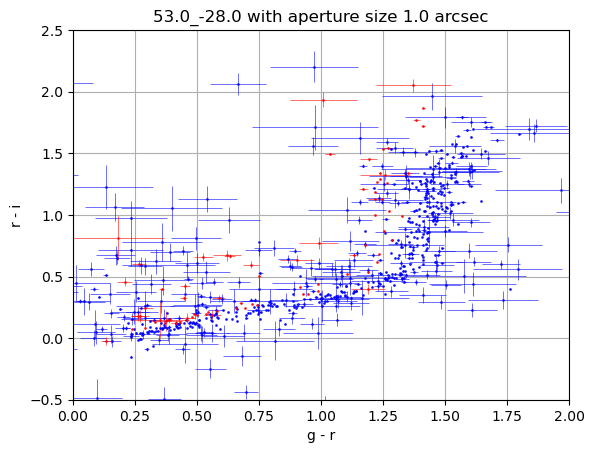

In [52]:
filter_1 = 'flux_DES-G'   # e.g., master_table column name
filter_2 = 'flux_DES-R'
filter_3 = 'flux_DES-R'
filter_4 = 'flux_DES-I'

with plt.rc_context({
    'xtick.bottom': True,
    'xtick.labelbottom': True,
    'ytick.left': True,
    'ytick.labelleft': True,
    'axes.edgecolor': 'black',
    'axes.grid': True
}):
    # Compute colors from master_table fluxes
    x_color = -2.5 * np.log10(master_table[filter_1] / master_table[filter_2])
    y_color = -2.5 * np.log10(master_table[filter_3] / master_table[filter_4])

    # Compute errors from sigma dictionary
    xerr = 2.5 / np.log(10) * np.sqrt(
        (sigma[filter_1[5:]] / master_table[filter_1])**2 +
        (sigma[filter_2[5:]] / master_table[filter_2])**2
    )
    yerr = 2.5 / np.log(10) * np.sqrt(
        (sigma[filter_3[5:]] / master_table[filter_3])**2 +
        (sigma[filter_4[5:]] / master_table[filter_4])**2
    )

    # Optional: filter points with very large errors
    mask = (xerr**2 + yerr**2 < .1) & (master_table['CLASS_STAR'] >= 0.6)

    # Plot
    plt.errorbar(
        x_color[mask], y_color[mask],
        xerr=xerr[mask], yerr=yerr[mask],
        fmt='o', c='b', ms=1, elinewidth=0.5, alpha=0.8
    )

    filter_1 = 'flux_g'   # e.g., master_table column name
    filter_2 = 'flux_r'
    filter_3 = 'flux_r'
    filter_4 = 'flux_i'

    # Compute colors from master_table fluxes
    x_color = -2.5 * np.log10(master_table[filter_1] / master_table[filter_2])
    y_color = -2.5 * np.log10(master_table[filter_3] / master_table[filter_4])

    # Compute errors from sigma dictionary
    xerr = 2.5 / np.log(10) * np.sqrt(
        (sigma[filter_1[5:]] / master_table[filter_1])**2 +
        (sigma[filter_2[5:]] / master_table[filter_2])**2
    )
    yerr = 2.5 / np.log(10) * np.sqrt(
        (sigma[filter_3[5:]] / master_table[filter_3])**2 +
        (sigma[filter_4[5:]] / master_table[filter_4])**2
    )

    # Optional: filter points with very large errors
    mask = (xerr**2 + yerr**2 < .1) & (master_table['CLASS_STAR'] >= 0.6)

    # Plot
    plt.errorbar(
        x_color[mask], y_color[mask],
        xerr=xerr[mask], yerr=yerr[mask],
        fmt='o', c='r', ms=1, elinewidth=0.5, alpha=0.8
    )

    plt.title(f'{field} with aperture size {aperture_size/5} arcsec')
    plt.xlabel(f'{filter_1[5:]} - {filter_2[5:]}')
    plt.ylabel(f'{filter_3[5:]} - {filter_4[5:]}')
    plt.xlim(0, 2)
    plt.ylim(-0.5, 2.5)
    plt.show()

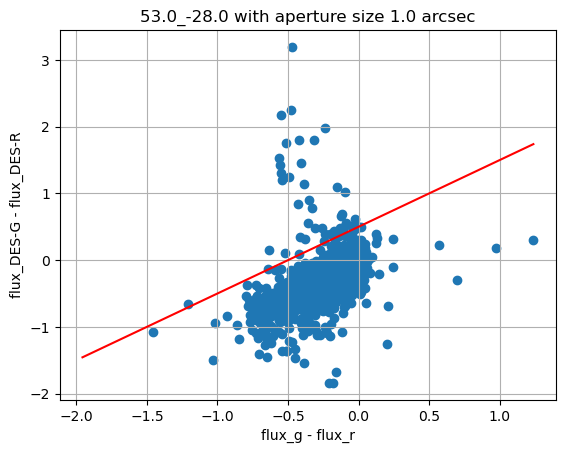

In [53]:
filter_1 = 'flux_g'   # e.g., master_table column name
filter_2 = 'flux_r'
filter_3 = 'flux_DES-G'
filter_4 = 'flux_DES-R'

with plt.rc_context({
    'xtick.bottom': True,
    'xtick.labelbottom': True,
    'ytick.left': True,
    'ytick.labelleft': True,
    'axes.edgecolor': 'black',
    'axes.grid': True
}):
    # Compute colors from master_table fluxes
    x_color = np.log10(master_table[filter_1]/master_table[filter_2])
    y_color = np.log10(master_table[filter_3]/master_table[filter_4])

    # Plot
    plt.scatter(x_color, y_color)
    plt.plot([np.nanmin(x_color)-0.5, np.nanmax(x_color)], [np.nanmin(x_color), np.nanmax(x_color)+0.5], c='r')
    plt.title(f'{field} with aperture size {aperture_size/5} arcsec')
    plt.xlabel(f'{filter_1} - {filter_2}')
    plt.ylabel(f'{filter_3} - {filter_4}')
    plt.show()


In [54]:
with open(f'{location}/{field}/master_table_{aperture_size/5}".pkl', 'wb') as f:
    pickle.dump(master_table, f)
with open(f'{location}/{field}/sigma_table_{aperture_size/5}".pkl', 'wb') as f:
    pickle.dump(sigma, f)

In [57]:
master_table.columns

Index(['id', 'ra', 'dec', 'CLASS_STAR', 'flux_u', 'flux_g', 'flux_r', 'flux_i',
       'flux_y', 'flux_z', 'flux_VIS', 'flux_DES-G', 'flux_DES-R',
       'flux_DES-I', 'flux_NIR-Y', 'flux_NIR-J', 'flux_NIR-H'],
      dtype='object')

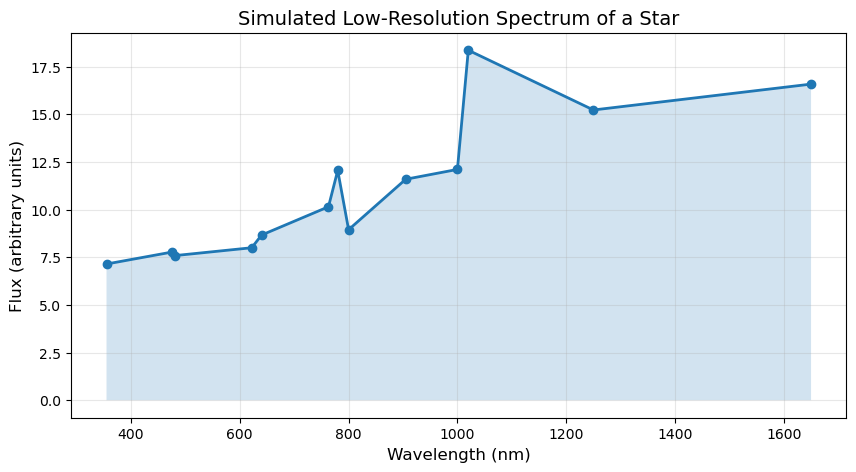

In [73]:
star = rows_with_all_flux.iloc[1200]

# Filters in correct spectral order (u → g → r → i → z → y → VIS → DES → NIR)
filters = [
    'flux_u', 'flux_g', 'flux_r', 'flux_i', 'flux_z', 'flux_y',
    'flux_VIS', 'flux_DES-G', 'flux_DES-R', 'flux_DES-I',
    'flux_NIR-Y', 'flux_NIR-J', 'flux_NIR-H'
]

# Approximate effective wavelengths in nanometers
# (values are typical for SDSS, DES, Euclid, NIR)
wavelengths = np.array([
    355, 475, 622, 763, 905, 1000,      # u g r i z y
    800,                                # VIS (Euclid broad band)
    480, 640, 780,                      # DES G R I
    1020, 1250, 1650                    # NIR Y J H
])
order = np.argsort(wavelengths)
fluxes = star[filters].values.astype(float)

# Mask invalid or zero fluxes
mask = np.isfinite(fluxes) & (fluxes > 0)
wavelengths = wavelengths[mask]
fluxes = fluxes[mask]

# Plot
plt.figure(figsize=(10, 5))
plt.plot(wavelengths[order], fluxes[order], marker='o', linestyle='-', linewidth=2)
plt.fill_between(wavelengths[order], fluxes[order], alpha=0.2)  # spectrum-like shading

plt.xlabel("Wavelength (nm)", fontsize=12)
plt.ylabel("Flux (arbitrary units)", fontsize=12)
plt.title("Simulated Low-Resolution Spectrum of a Star", fontsize=14)
plt.grid(alpha=0.3)
plt.show()